### About this Dataset


## PJM Hourly Energy Consumption Data

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

In [186]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from math import sqrt

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import joblib
import os

os.chdir(r"C:\Users\willi\GitHub\TS_Energy_Consumption_XGB\data\raw")

In [151]:
PJME_data = pd.read_csv("PJME_hourly.csv")
PJME_data = PJME_data.set_index("Datetime")
PJME_data.index = pd.to_datetime(PJME_data.index)
print("✅ Data loaded successfully")

✅ Data loaded successfully


In [152]:
PJME_data.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [153]:
PJME_data.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


<function matplotlib.pyplot.show(close=None, block=None)>

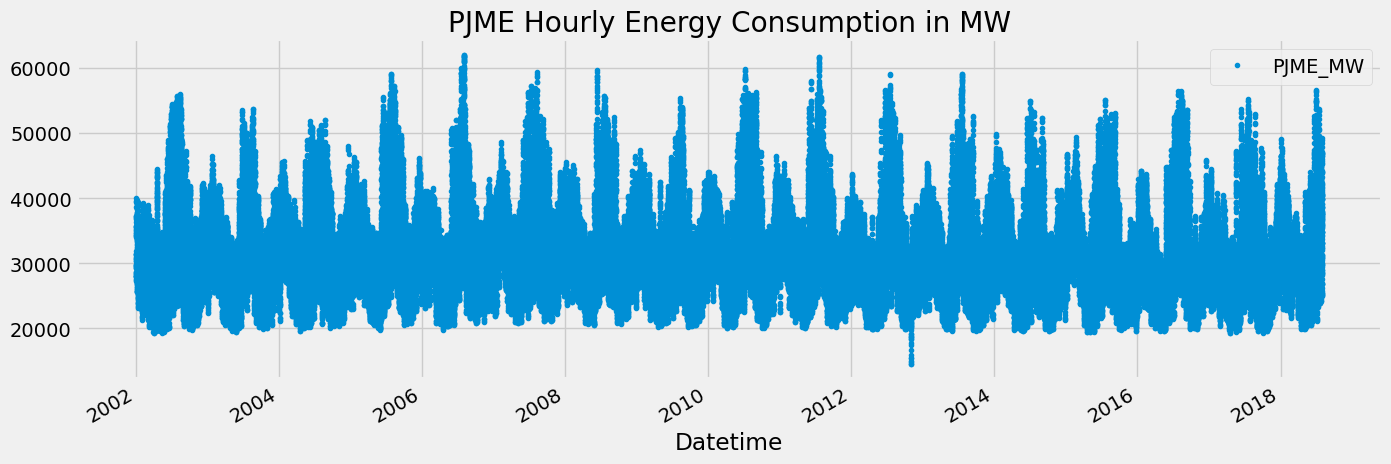

In [154]:
PJME_data.plot(style=".", 
               figsize=(15, 5),
               color=color_pal[0],               
               title="PJME Hourly Energy Consumption in MW",)
plt.show

## Train / Test Spilt

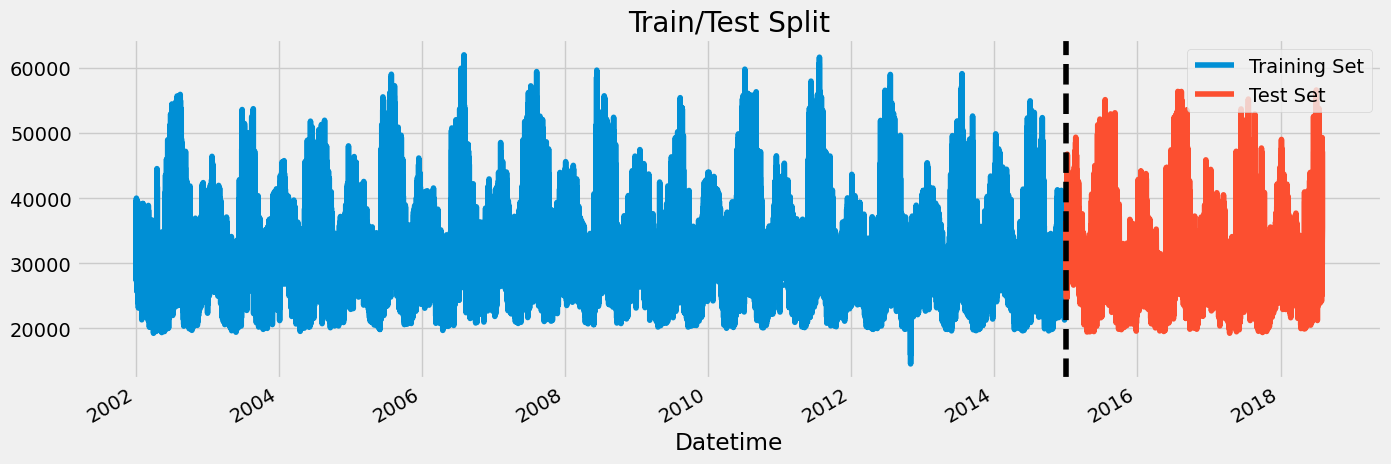

In [155]:
train = PJME_data.loc[PJME_data.index < "01-01-2015"]
test = PJME_data.loc[PJME_data.index >= "01-01-2015"]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label = "Training Set", title="Train/Test Split")
test.plot(ax=ax, label = "Test Set")
ax.axvline("01-01-2015", color="black", linestyle="--")
ax.legend(["Training Set", "Test Set"])
plt.show()

#### Plot of Single week of Data

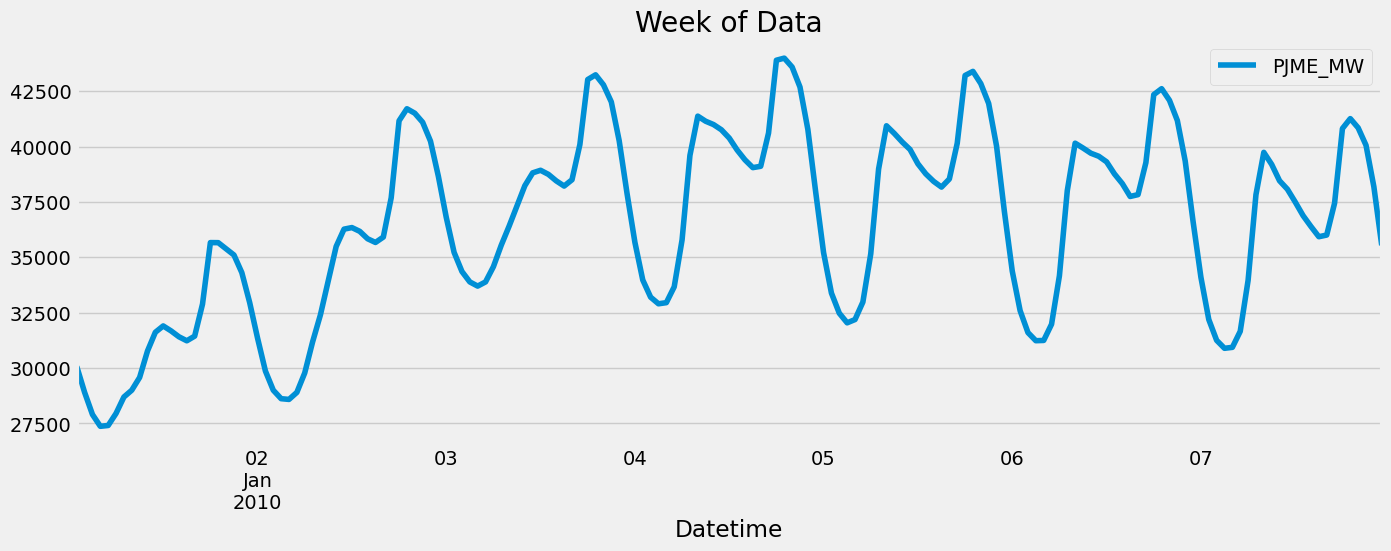

In [156]:
# Ensure PJME_data is sorted by its index
PJME_data_sorted = PJME_data.sort_index()

#Plot from the sorted DataFrame
PJME_data_sorted.loc[(PJME_data_sorted.index > "01-01-2010") & (PJME_data_sorted.index < "01-08-2010")] \
    .plot(figsize=(15, 5), title="Week of Data")
plt.show()

## Feature Creation

In [157]:

def create_features(df):
    """
    Create time-based features from the index of the DataFrame.
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["dayofyear"] = df.index.dayofyear
    df["year"] = df.index.year
    return df


In [158]:
PJME_data = create_features(PJME_data)

## Visualise the Feature / Target Relationship

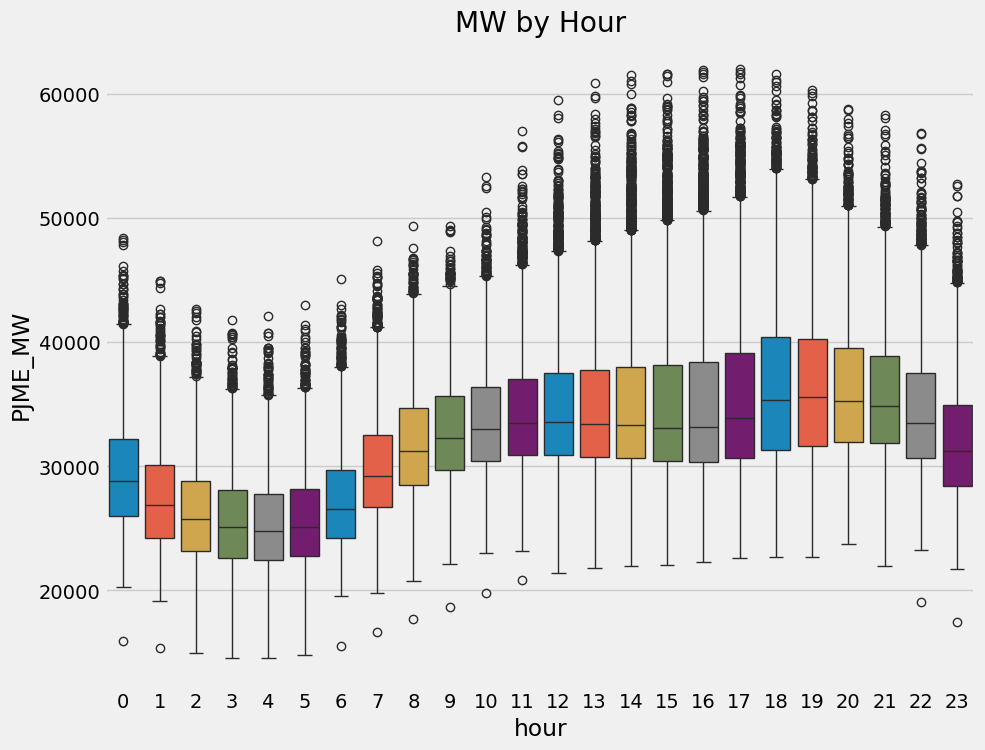

In [159]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=PJME_data, x="hour", y="PJME_MW", palette=color_pal)
ax.set_title("MW by Hour")
plt.show()

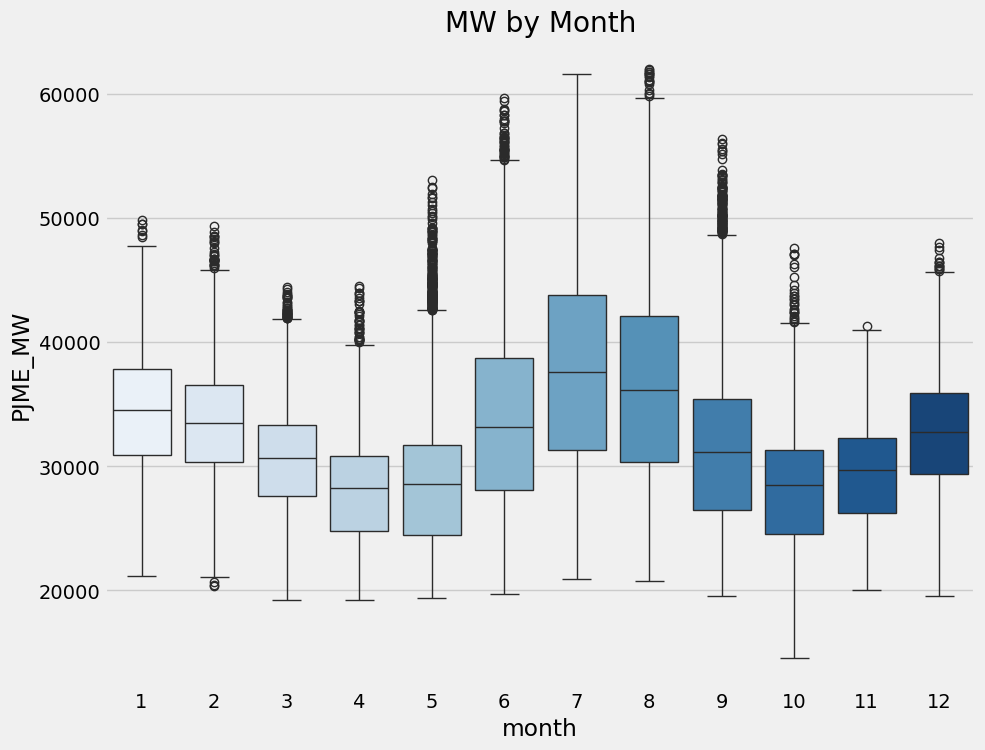

In [160]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=PJME_data, x="month", y="PJME_MW", palette="Blues")
ax.set_title("MW by Month")
plt.show()

In [161]:
## Save the processed data
# Set Directory for saving processed data
os.chdir(r"C:\Users\willi\GitHub\TS_Energy_Consumption_XGB\data\processed")
PJME_data.to_csv("PJME_Clean.csv")

In [162]:
# Save the train and test sets
train.to_csv("PJME_Train.csv")
test.to_csv("PJME_Test.csv")
print("✅ Processed data saved successfully")

✅ Processed data saved successfully


# Create Model

In [163]:
train = create_features(train)
test = create_features(test)

FEATURES = ["hour", "dayofweek", "quarter", "month", "dayofyear", "year"]
TARGET = "PJME_MW"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [164]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729
[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[988]	validation_0-rmse:3060.25324	validation_1-rmse:3728.07396


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

## Feature Importance

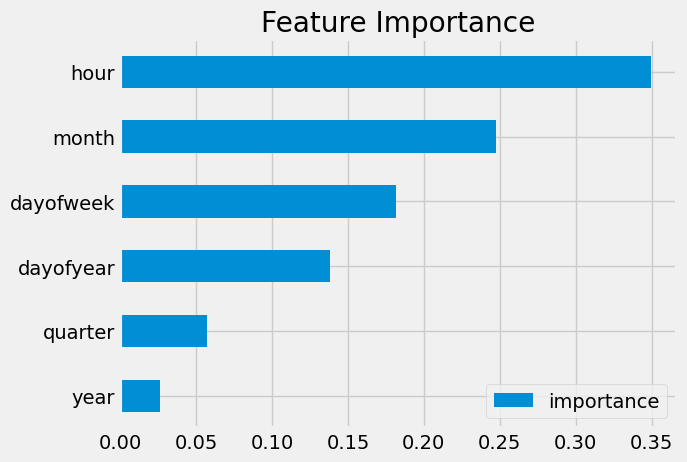

In [165]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns =["importance"])
fi.sort_values("importance").plot(kind='barh', title='Feature Importance')
plt.show()

### Forecast on Test

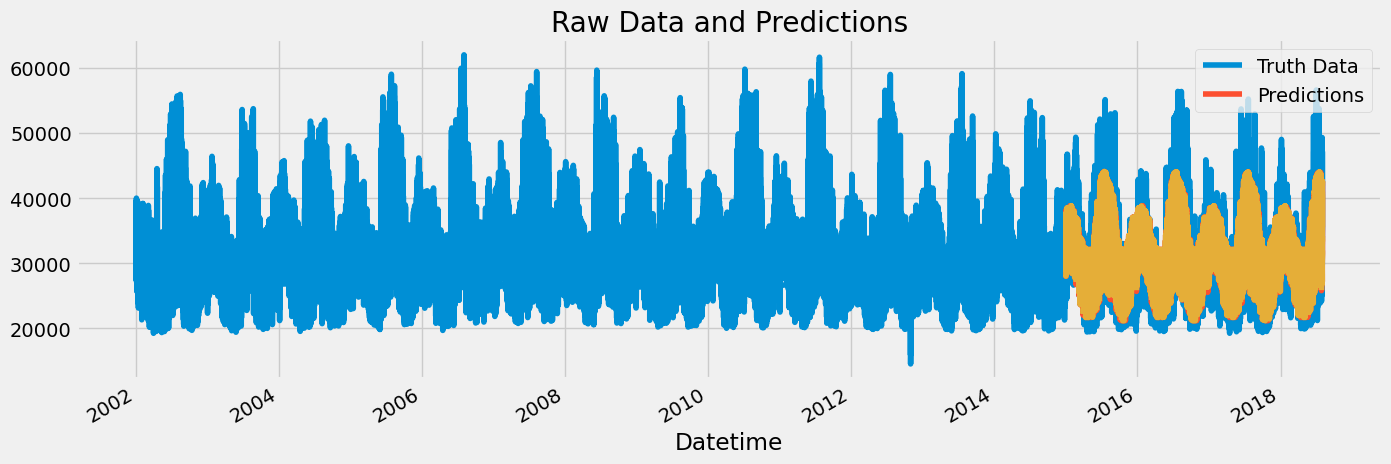

In [166]:
test["prediction"] = reg.predict(X_test)

# Columns that might conflict after multiple runs
cols_to_drop = ['prediction', 'prediction_x', 'prediction_y']
for col in cols_to_drop:
    if col in PJME_data.columns:
        PJME_data = PJME_data.drop(columns=[col])

# Now perform the merge
PJME_data = PJME_data.merge(test[["prediction"]], how='left', left_index=True, right_index=True)

# Rest of your plotting code
ax = PJME_data[["PJME_MW", "prediction"]].plot(figsize=(15, 5))
# Ensure the 'prediction' column exists and is what you expect before plotting
if "prediction" in PJME_data:
    PJME_data["prediction"].plot(ax=ax, style="-.")
else:
    print("Warning: 'prediction' column not found in PJME_data after merge.")
ax.set_title("Raw Data and Predictions")
ax.legend(["Truth Data", "Predictions"]) # Adjust legend based on what's plotted
plt.show()

##           Visualizing Predictions vs. Actual

###### We overlay the predicted vs actual energy consumption to visually assess performance

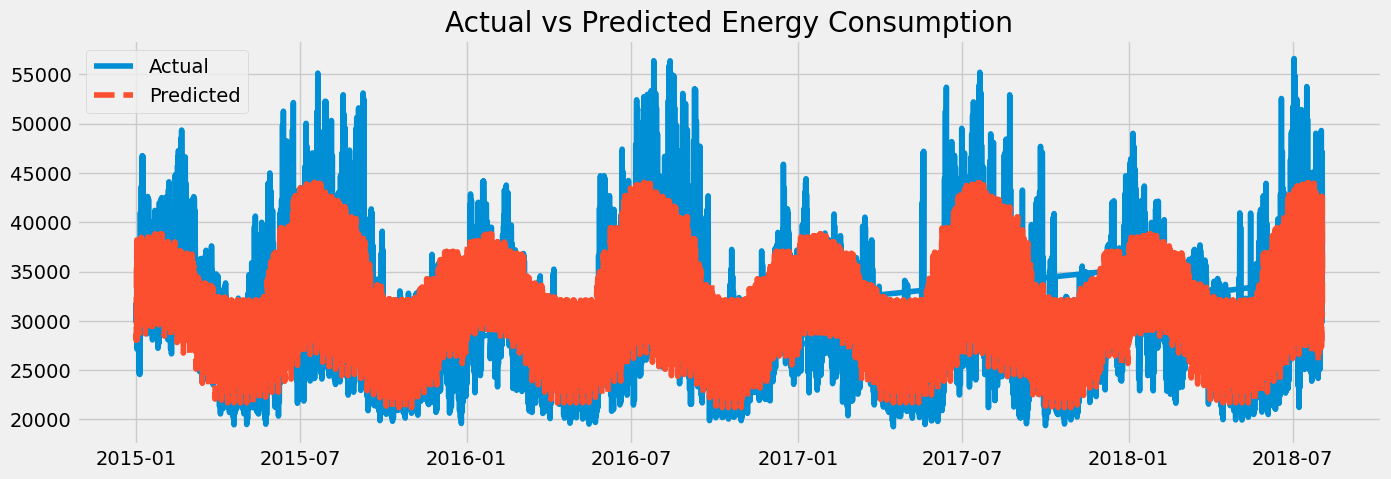

In [167]:
# Plot the entire test set
plt.figure(figsize=(15, 5))
plt.plot(test.index, test['PJME_MW'], label='Actual')
plt.plot(test.index, test['prediction'], label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Energy Consumption')
plt.legend()
plt.show()

#### Focused view on a weeks actual vs predicted

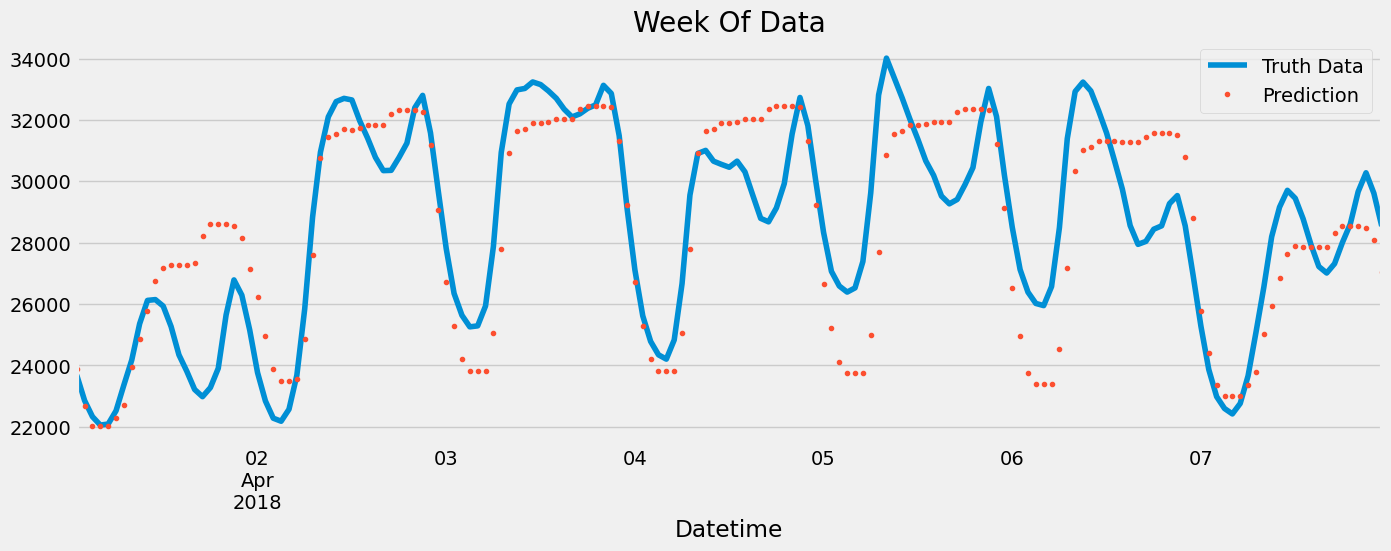

In [168]:
# Ensure the DataFrame is sorted by its time index first!
PJME_data = PJME_data.sort_index()


ax = PJME_data.loc[(PJME_data.index > '04-01-2018') & (PJME_data.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')

PJME_data.loc[(PJME_data.index > '04-01-2018') & (PJME_data.index < '04-08-2018')]['prediction'] \
    .plot(style='.')

plt.legend(['Truth Data', 'Prediction'])
plt.show()

Although the model captures the general shape of the demand there is some clear underfitting/lagging behind the peaks.  As such parameter tuning will be the next logical step.

### <ins> Key Parameters to Tune </ins>

| Parameter               | Purpose                                            |
| ----------------------- | -------------------------------------------------- |
| `max_depth`             | Controls model complexity                          |
| `learning_rate`         | Lower = slower but safer learning                  |
| `n_estimators`          | Total trees to fit                                 |
| `subsample`             | Fraction of rows used per tree                     |
| `colsample_bytree`      | Fraction of features used per tree                 |
| `early_stopping_rounds` | Stops training if validation score doesn't improve |


In [169]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [500, 1000],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb_model = XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

# Run grid search (this may take a few minutes)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.05], 'max_depth': [3, 5],
                         'n_estimators': [500, 1000], 'subsample': [0.8, 1]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [170]:
# Train model manually to avoid confusion when using GridSearchCV with XGBoost!

# Manually specify and override key values

reg_tuned = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.01,
    max_depth=3,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=1.0,
    eval_metric='rmse',
    early_stopping_rounds=20  # Move this here
)

reg_tuned.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)


[0]	validation_0-rmse:6496.43280
[1]	validation_0-rmse:6471.58512
[2]	validation_0-rmse:6447.16674
[3]	validation_0-rmse:6423.12593
[4]	validation_0-rmse:6399.53100
[5]	validation_0-rmse:6376.72725
[6]	validation_0-rmse:6354.23358
[7]	validation_0-rmse:6331.77231
[8]	validation_0-rmse:6310.03606
[9]	validation_0-rmse:6288.61700
[10]	validation_0-rmse:6267.19352
[11]	validation_0-rmse:6246.16606
[12]	validation_0-rmse:6225.86367
[13]	validation_0-rmse:6206.07188
[14]	validation_0-rmse:6186.04124
[15]	validation_0-rmse:6166.37670
[16]	validation_0-rmse:6147.48808
[17]	validation_0-rmse:6128.44320
[18]	validation_0-rmse:6109.93104
[19]	validation_0-rmse:6082.58733
[20]	validation_0-rmse:6064.18433
[21]	validation_0-rmse:6046.35043
[22]	validation_0-rmse:6028.91057
[23]	validation_0-rmse:6002.66487
[24]	validation_0-rmse:5976.80099
[25]	validation_0-rmse:5951.21865
[26]	validation_0-rmse:5934.22137
[27]	validation_0-rmse:5917.64036
[28]	validation_0-rmse:5901.39460
[29]	validation_0-rmse:5

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

#### We check for the best model:

In [171]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {-grid_search.best_score_:.2f}")


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 1}
Best RMSE: 3392.81


### Re-Evaluation After Tuning


In [172]:
# Generate predictions from the tuned model

test['prediction_tuned'] = reg_tuned.predict(X_test)


#### Visualize Prediction vs Actuals (Zoomed View) after Tuning

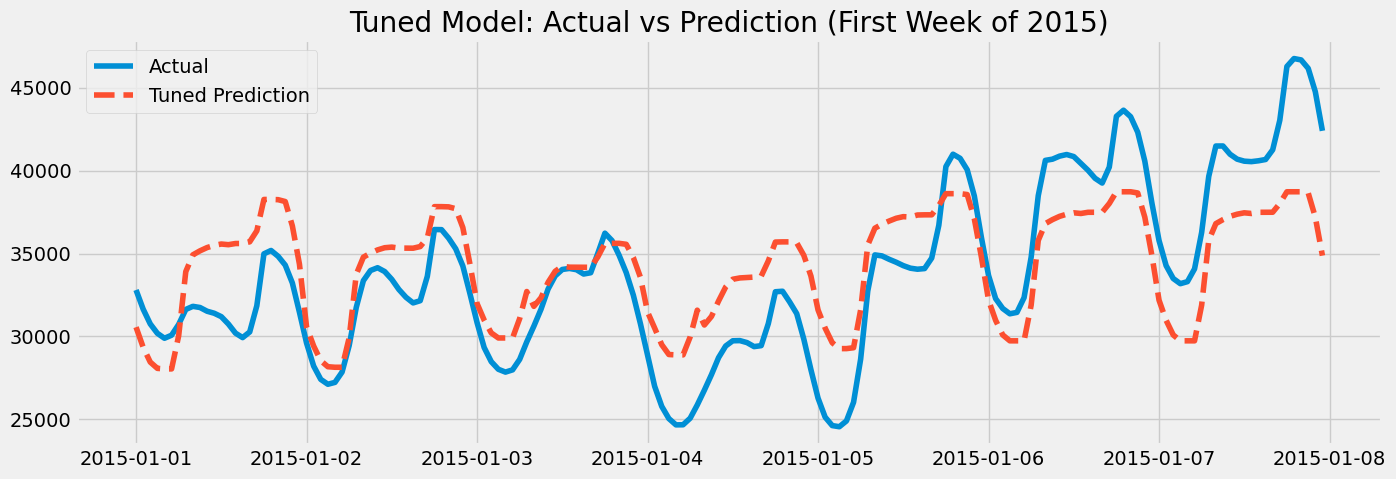

In [173]:
test = test.sort_index()

# Zoomed view for evaluation
zoomed = test.loc['2015-01-01':'2015-01-07']
plt.figure(figsize=(15, 5))
plt.plot(zoomed.index, zoomed['PJME_MW'], label='Actual')
plt.plot(zoomed.index, zoomed['prediction_tuned'], label='Tuned Prediction', linestyle='--')
plt.title('Tuned Model: Actual vs Prediction (First Week of 2015)')
plt.legend()
plt.show()



#### RMSE Score

###### Measuring the average difference between a statistical models predicted values and actual values comparing the tuned vs the original scores.

In [174]:
rmse_tuned = sqrt(mean_squared_error(test['PJME_MW'], test['prediction_tuned']))
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'📉 RMSE Score on Test set: {score:0.2f}')
print(f"📉 Tuned RMSE on Test Set: {rmse_tuned:.2f}")

📉 RMSE Score on Test set: 3726.80
📉 Tuned RMSE on Test Set: 3743.56


## Forecasting Future Values

In [175]:
# Generate Future time stamps

# Starting from the latest timestamp in the dataset

last_timestamp = PJME_data.index.max()

# Generate hourly timestamps for 7 future days
future_dates = pd.date_range(
    start=last_timestamp + pd.Timedelta(hours=1),
    periods=24 * 7,  # 7 days * 24 hours
    freq='H'
)


##### Create Time based features for the future dates

In [182]:

# Create future dates
future_dates = pd.date_range(
    start=PJME_data.index.max() + pd.Timedelta(hours=1),
    periods=24 * 7,  # next 7 days hourly
    freq='H'
)

# Create DataFrame and generate ONLY the features used in training
future_df = pd.DataFrame(index=future_dates)
future_df['hour'] = future_df.index.hour
future_df['dayofweek'] = future_df.index.dayofweek
future_df['quarter'] = future_df.index.quarter
future_df['month'] = future_df.index.month
future_df['dayofyear'] = future_df.index.dayofyear
future_df['year'] = future_df.index.year

#### Forecast using `re-tuned`

In [184]:
# Predict future values
future_df['forecast'] = reg_tuned.predict(future_df[FEATURES])



#### Plot Forecast vs Last Week

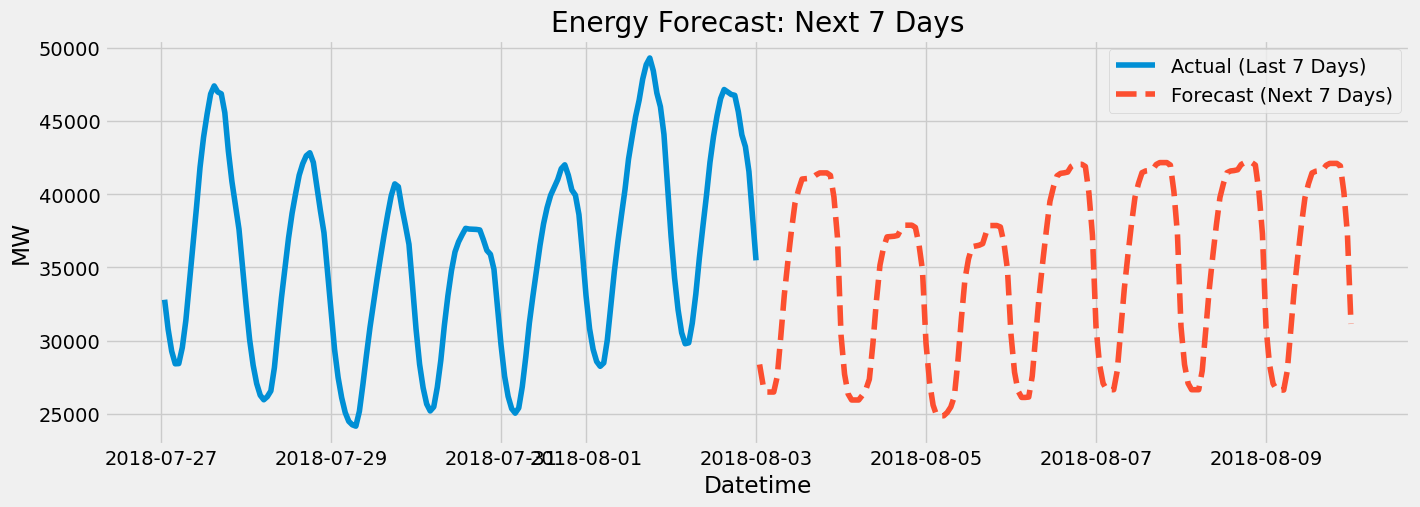

In [185]:
plt.figure(figsize=(15, 5))
plt.plot(PJME_data.index[-24*7:], PJME_data['PJME_MW'][-24*7:], label='Actual (Last 7 Days)')
plt.plot(future_df.index, future_df['forecast'], label='Forecast (Next 7 Days)', linestyle='--')
plt.title('Energy Forecast: Next 7 Days')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend()
plt.show()


## Save Model for Re-use

In [189]:
# Set the directory for saving the model

os.chdir(r"C:\Users\willi\GitHub\TS_Energy_Consumption_XGB\models")

In [191]:
# Save model
joblib.dump(reg_tuned, "xgb_energy_forecast_model.joblib")
print(f"✅ Model saved successfully")

✅ Model saved successfully
